In [5]:
import torch 
import matplotlib.pyplot as plt   
import os          
import math
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
legend_font = 11
axis_font = 15
lw = 2
impth = '../IMG/'

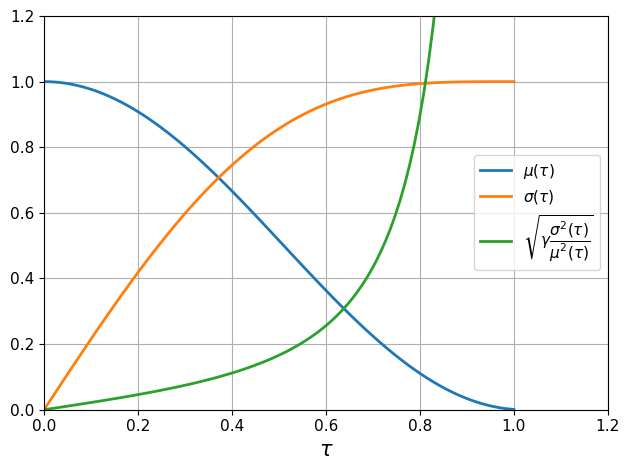

In [6]:
# Diffusion scheduling
eps = 1e-3
gam = 1e-2

def alpha(t):
    return torch.cos(math.acos(math.sqrt(eps))*t)**2

def mu(t):
    return alpha(t)

def sigma(t):
    return (1 - alpha(t)**2 + eps**2).sqrt()

def PLSvar(t):
    return gam*(sigma(t)**2)/(mu(t)**2)

t = torch.linspace(0,1,100)

plt.plot(t, mu(t), label = r'$\mu(\tau)$', linewidth = lw)
plt.plot(t, sigma(t), label = r'$\sigma(\tau)$', linewidth = lw)
plt.plot(t, PLSvar(t).sqrt(), label = r'$\sqrt{\gamma\dfrac{\sigma^2(\tau)}{\mu^2(\tau)}}$', linewidth = lw)
plt.ylim([0,1.2])
plt.xlim([0,1.2])
plt.xlabel(r'$\tau$', fontsize = axis_font)
plt.tick_params('both', labelsize = legend_font)
plt.grid()
plt.legend(fontsize = legend_font)
plt.tight_layout()
plt.savefig(impth+'scheduling.pdf')
plt.show()


tensor([[1., 0.],
        [0., 1.]])


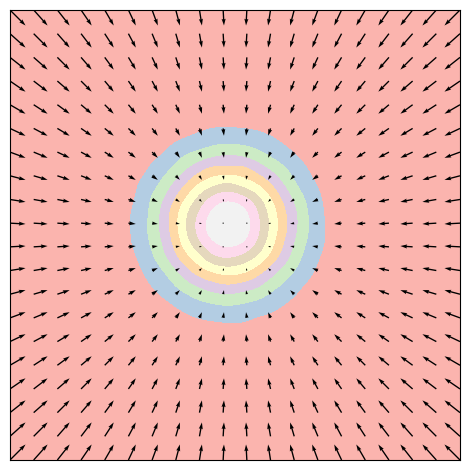

In [7]:
from torch.distributions import MultivariateNormal

sigm = torch.eye(2)
# sigm[0,1] = torch.rand(1)
# sigm[1,0] = torch.rand(1)

var = sigm@sigm.T
print(var)
dist = MultivariateNormal(torch.zeros(2), var)

s = dist.sample((2**20,))
h, _,_,_ = plt.hist2d(np.array(s[:,0]), np.array(s[:,1]), bins = 30)
plt.close()
plt.imshow(np.flip(h,1).T, interpolation = 'spline36', 
           extent = [-3*var[0,0],3*var[0,0],-3*var[1,1],3*var[1,1]],
           cmap = 'Pastel1')
x = torch.linspace(-3*var[0,0],3*var[0,0],20)
y = torch.linspace(-3*var[1,1],3*var[1,1],20)
a = plt.gca()
a.set_xticks(x)
a.set_yticks(y)
xy = torch.meshgrid(x,y,indexing = 'ij')

xyv = torch.cat([l.unsqueeze(0) for l in xy], dim = 0)
score = torch.linalg.inv(var)@((-xyv).reshape(2,-1))
score = score.reshape(2,20,20)
plt.quiver(xy[0], xy[1], score[0], score[1])
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.savefig(impth+'iso_score.pdf')
plt.show()


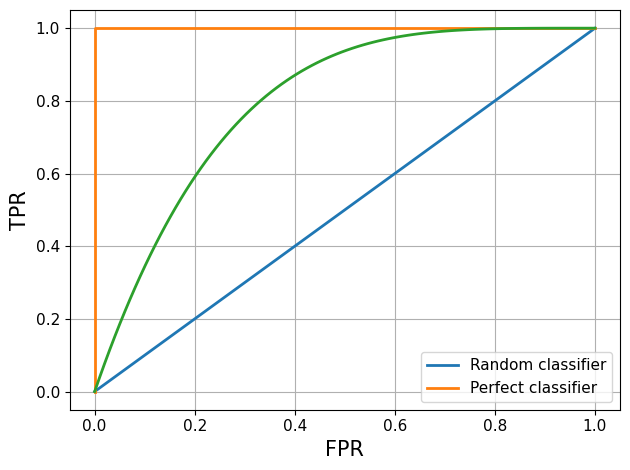

In [8]:
# ROC

x = torch.linspace(0,1,100)
y = torch.linspace(0,1,100)

plt.plot(x,y, label = 'Random classifier', linewidth = lw)
plt.plot([0,0,1],[0,1,1], label = 'Perfect classifier', linewidth = lw)
plt.plot(x,1-(1-x)**4, linewidth = lw)
plt.xlabel('FPR', fontsize = axis_font)
plt.ylabel('TPR', fontsize = axis_font)
plt.legend(fontsize = legend_font)
plt.grid()
plt.tick_params('both', labelsize = legend_font)
plt.tight_layout()
plt.savefig(impth+'AUROC.pdf')
plt.show()

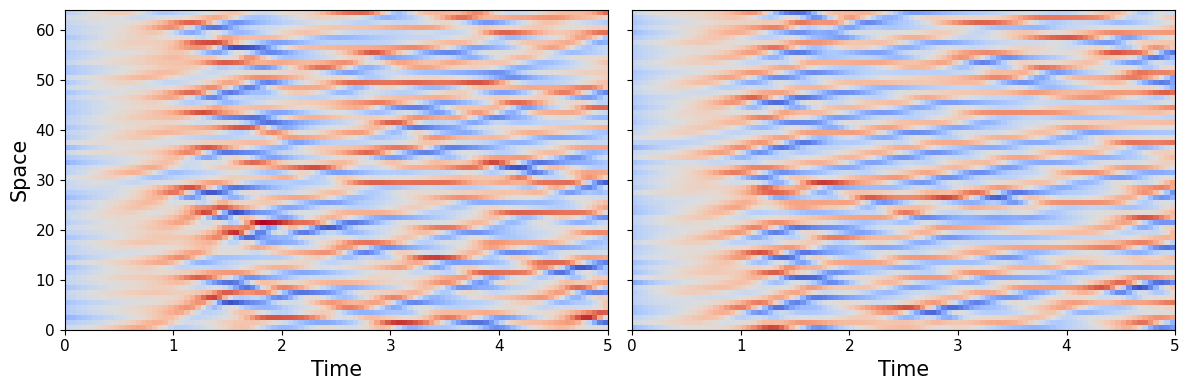

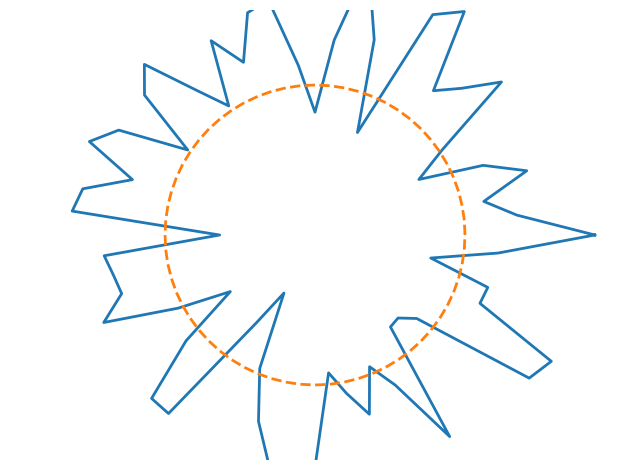

In [58]:
from dasbi.simulators.sim_lorenz96 import LZ96 as sim 

N = 64
s64 = sim(N, 8, .5)
times = torch.linspace(0,5,100)
s64.generate_steps(torch.randn((2,N)), times, observe=False)

fig,ax = plt.subplots(1,2, sharey='row', figsize = (12,4))

minv = torch.minimum(s64.data[0].min(),s64.data[1].min())
maxv = torch.maximum(s64.data[0].max(),s64.data[1].max())

ax[0].imshow(s64.data[0].T, cmap='coolwarm', extent = [0,5,0,N], aspect = 'auto', vmin = minv, vmax = maxv)
ax[1].imshow(s64.data[1].T, cmap='coolwarm', extent = [0,5,0,N], aspect = 'auto', vmin = minv, vmax = maxv)
ax[0].set_ylabel('Space', fontsize = axis_font)
ax[0].set_xlabel('Time', fontsize = axis_font)
ax[1].set_xlabel('Time', fontsize = axis_font)
ax[0].tick_params('both', labelsize = legend_font)
ax[1].tick_params('both', labelsize = legend_font)


plt.tight_layout()
plt.savefig(impth+'LZ96.pdf')

plt.show()

def polar_plot_lz(data, N, ensemble = False, offset = 10, gt = None, mask = None):
    th = torch.linspace(0,2*torch.pi,N+1)
    rad = offset
    
    if not ensemble:
        dispdat = torch.cat((data, data[:1]), dim = 0)
        plt.plot((rad + dispdat)*th.cos(), (rad + dispdat)*th.sin(), linewidth = lw)
        plt.plot(rad*th.cos(), rad*th.sin(), '--', linewidth = lw)

    else:
        width = 8*lw/data.shape[0]

        for d in data:
            d = d.squeeze()
            dispdat = torch.cat((d, d[:1]), dim = 0)
            plt.plot((rad + dispdat)*th.cos(), (rad + dispdat)*th.sin(), '0.7', linewidth = width, 
                     alpha = .1)     

        if mask is not None:
            for i,m in enumerate(mask.squeeze()):
                if m:
                    plt.plot([0, rad*th[i].cos()],[0, rad*th[i].sin()], 'g--', linewidth = lw)
        dispdat = torch.cat((gt, gt[:1]), dim = 0)
        plt.plot((rad + dispdat)*th.cos(), (rad + dispdat)*th.sin(), linewidth = lw)
        plt.plot(rad*th.cos(), rad*th.sin(), '--', linewidth = lw)       
    
    ax = plt.gca()
    ax.axis('equal')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.gca().axis('off')
    plt.xlim(-rad-0.5*rad, rad+0.5*rad)
    plt.ylim(-rad-0.5*rad, rad+0.5*rad)
    plt.tight_layout()
    
polar_plot_lz(s64.data[0,50], N)


torch.Size([103, 64, 2, 64, 64])
torch.Size([1, 2, 64, 64])


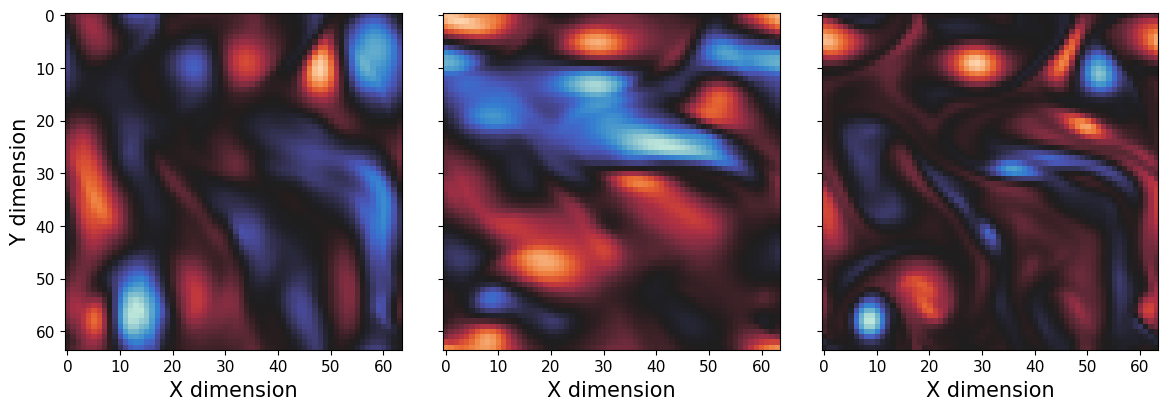

In [10]:
from KOLMO_LIN import vorticity, load_data
import seaborn as sns

color = sns.color_palette("icefire", as_cmap=True)
path_test = '../test.h5'
data = load_data(path_test)
print(data.shape)
data = data[0,torch.randint(64,(1,))]
print(data.shape)

fig,ax = plt.subplots(1,3, sharey='row', figsize = (12,4))

ax[0].imshow(data[0,0], cmap = color)
ax[1].imshow(data[0,1], cmap = color)
ax[2].imshow(vorticity(data[0]), cmap = color)

ax[0].set_ylabel('Y dimension', fontsize = axis_font)
ax[0].set_xlabel('X dimension', fontsize = axis_font)
ax[1].set_xlabel('X dimension', fontsize = axis_font)
ax[2].set_xlabel('X dimension', fontsize = axis_font)

ax[0].tick_params('both', labelsize = legend_font)
ax[1].tick_params('both', labelsize = legend_font)
ax[2].tick_params('both', labelsize = legend_font)

plt.tight_layout()
plt.savefig(impth+'KOLMO.pdf')

plt.show()


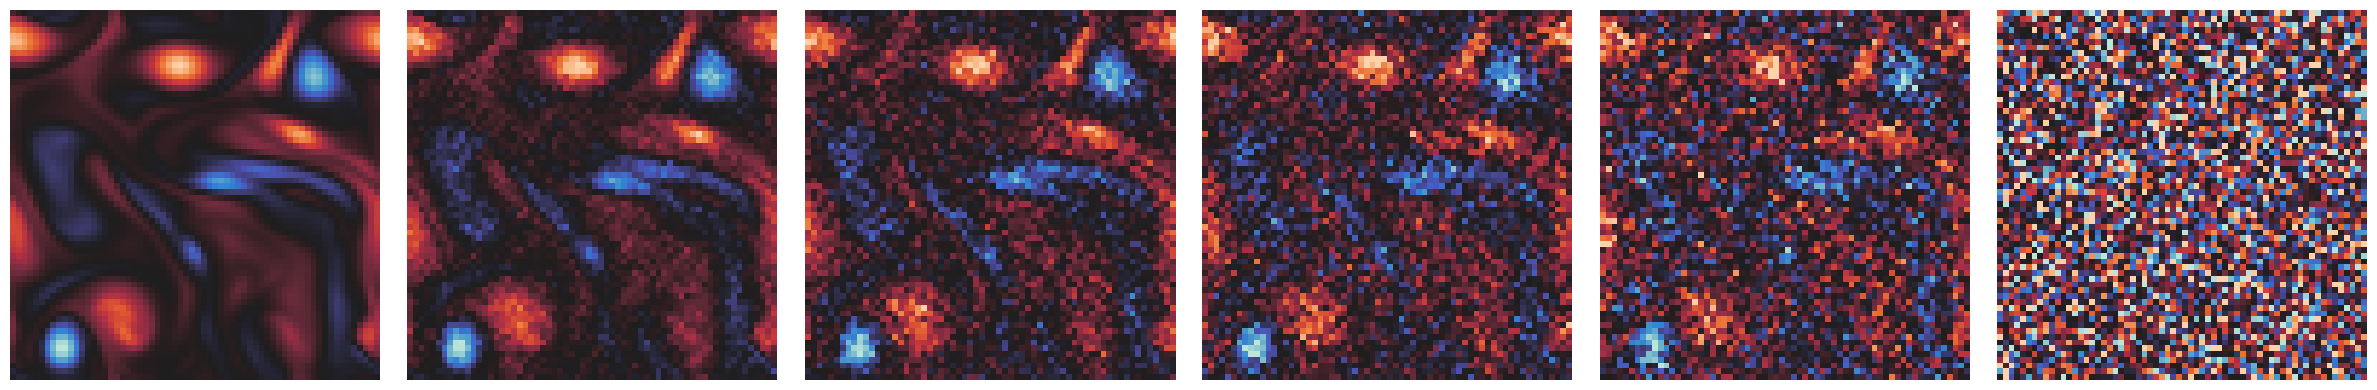

In [11]:
alpha = lambda t : torch.cos(math.acos(math.sqrt(1e-3))*t)**2

def mu(t):
        return alpha(t)

def sigma(t):
    return (1 - alpha(t) ** 2 + 1e-6).sqrt()

def samp(x,t):
    eps = torch.randn_like(x)

    return mu(t)*x + sigma(t)*eps

idx = 0
fig, ax = plt.subplots(1,6, figsize = (24,4))
vmin,vmax = vorticity(data[0]).min(), vorticity(data[0]).max()
for i,tau in enumerate(torch.linspace(0,1,20)):
    if i not in range(5,19):
        ax[idx].imshow(vorticity(samp(data[0], tau)), cmap = color, vmin = vmin, vmax = vmax)
        ax[idx].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        ax[idx].axis('off')
        idx += 1
plt.tight_layout()
plt.savefig(impth+'KOLMO_diff.svg')

plt.show()

In [67]:
from LZ96_CONV import build, process_sim
import pickle 

def make_maf_lz_config(N,w):
    CONFIG = {
    # Architecture
    "embedding": 3,
    "hf": [32*int(N**0.5), ]*4,
    "tf": 3 + N//256,
    # Data
    "points": N,
    "noise": 0.5,
    "device": 'cuda',
    # Test with assimilation window
    "x_dim": (1, 1, N, 1),
    "y_dim": (1, w, N//4, 1),
    "y_dim_emb": (1, 11, N, 1),
    'obs_mask': True,
    "observer_fp": f"experiments/observer{N}LZ.pickle",
    }

    return CONFIG

def make_post_lz_config(N,w):
    dp = {
    8 : 2,
    16 : 2,
    32 : 2,
    64 : 3,
    128 : 3,
    256 : 4
    }

    CONFIG = {
    # Architecture
    "embedding": 3,
    "depth": dp[N],
    "input_h": 45 + int(np.log2(N)),
    # Data
    "points": N,
    "noise": 0.5,
    "device": 'cuda',
    # Test with assimilation window
    "x_dim": (1, 1, N, 1),
    "y_dim": (1, w, N//4, 1),
    "y_dim_emb": (1, 11, N, 1),
    'obs_mask': True, #+1 in y_dim
    "observer_fp": f"experiments/observer{N}LZ.pickle",
    }

    return CONFIG

def make_linp_lz_config(N,w):
    dp = {
        8 : 2,
        16 : 2,
        32 : 2,
        64 : 3,
        128 : 3,
        256 : 4
    }

    chan = {
        8 : 60,
        16 : 61,
        32 : 62,
        64 : 53,
        128 : 54,
        256 : 54
    }

    CONFIG = {
        # Architecture
        "embedding": 3,
        "depth": dp[N],
        "input_h": chan[N],
        # Data
        "points": N,
        "noise": 0.5,
        "device": 'cuda',
        # Test with assimilation window
        "x_dim": (1, 1, N, 1),
        "y_dim": (1, w, N//4, 1),
        "y_dim_emb": (1, 11, N, 1),
        'obs_mask': True, #+1 in y_dim
        "observer_fp": f"experiments/observer{N}LZ.pickle",
    }

    return CONFIG

def make_conv_lz_config(N,w):
    nms_dict = {
    8: 2,
    16: 2,
    32: 2,
    64: 3,
    128: 3,
    256: 4,
    }

    ms_mod = {
        8: 1,
        16: 1,
        32: 1,
        64: 2,
        128: 3,
        256: 4,
    }
    CONFIG = {
    # Architecture
    "embedding": 3,
    "kernel_size": 2,
    "ms_modules": ms_mod[N],
    "num_conv": 2,
    "N_ms": nms_dict[N],
    # Data
    "points": N,
    "noise": 0.5,
    "device": 'cuda',
    # Test with assimilation window
    "x_dim": (1, 1, N, 1),
    "y_dim": (1, w, N//4, 1),
    "y_dim_emb": (1, 11, N, 1),
    'obs_mask': True, #+1 in y_dim
    'ar': False, #+1 in y_dim_emb (for modargs not embnet)
    'roll':True,
    "observer_fp": f"experiments/observer{N}LZ.pickle",
    }

    return CONFIG

#DATA GENERATION
N = 8
observer_fp = f"experiments/observer{N}LZ.pickle"
# DATA
simsamp = sim(N, 8, .5)
times = torch.linspace(0,5,100)
with open(observer_fp, "rb") as handle:
    observer = pickle.load(handle)

simsamp.init_observer(observer)
simsamp.generate_steps(torch.randn((64000,N)), times)
mx, sx, my, sy, mt,st = process_sim(simsamp)

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


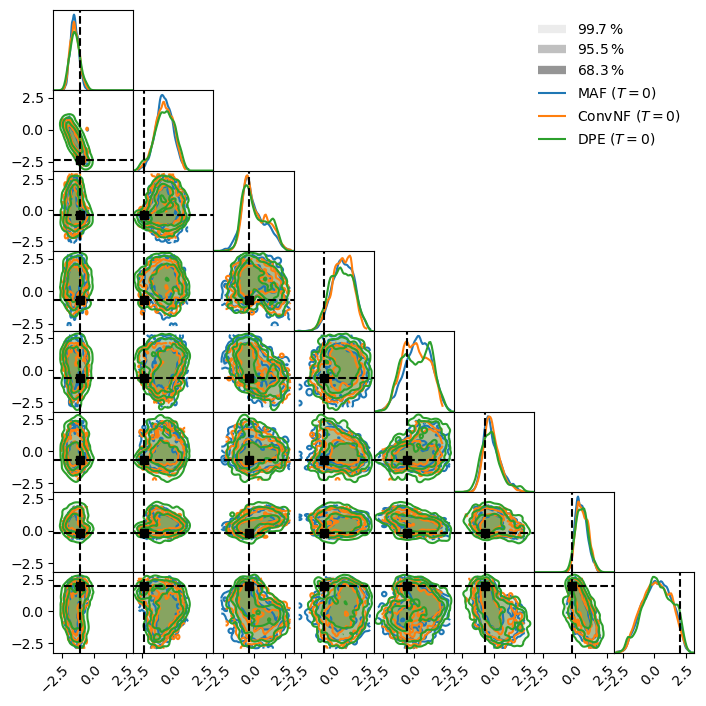

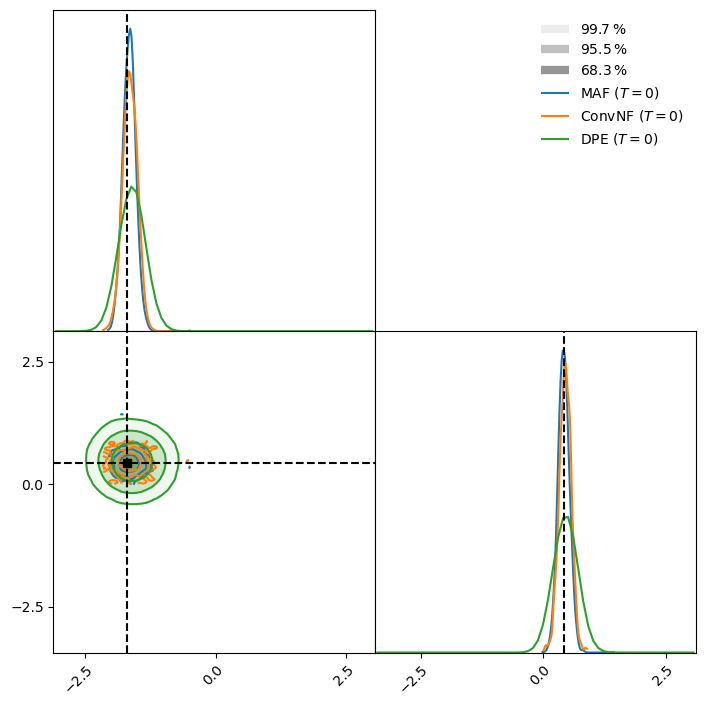

In [68]:
from LZ96_MAF import build as build1
from LZ96_CONV import build as build2

from lampe.plots import corner, mark_point

typeM1 = 'MAF'
samplerf1 = f'../checkpoints/LZ/{typeM1}/step/{N}/2.pth'
typeM2 = 'CONV'
samplerf2 = f'../checkpoints/LZ/{typeM2}/step/{N}/2.pth'

time = 50
window = 1

CONFIG1 = make_maf_lz_config(N,window)
CONFIG2 = make_conv_lz_config(N,window)

# Sampler
sampler1 = build1(**CONFIG1).to(CONFIG1['device'])
sampler2 = build2(**CONFIG2).to(CONFIG2['device'])
with torch.no_grad():
    sampler2(
        simsamp.data[None, None, 0, 0, :, None].to(CONFIG2['device']),
        simsamp.obs[None, :window, 0, :, None].to(CONFIG2['device']),
        simsamp.time[0, 0, None].to(CONFIG2['device']),
    )
state1 = torch.load(f"{samplerf1}", map_location=torch.device(CONFIG1['device']))
state2 = torch.load(f"{samplerf2}", map_location=torch.device(CONFIG2['device']))

sampler1.load_state_dict(state1)
sampler1.eval()
sampler2.load_state_dict(state2)
sampler2.eval()

x_star, y_star, t_star = simsamp.data[0,time], simsamp.obs[0,time], simsamp.time[0,time]
# pplz = lambda x,n:polar_plot_lz(x,n,offset=4)

# (1) REJECT
# yt = simsamp.obs[:,time]
# idx = (torch.isclose(y_star*sy + my, yt*sy + my, atol = 1.5).sum(dim = -1) == N//4)
# gt_post_x = simsamp.data[idx,time]
# gt_post_y = simsamp.obs[idx,time]
# print(gt_post_x.shape)

# (2) WEIGHT EVIDENCE
hy, biny = torch.histogramdd(simsamp.obs[:,time], bins=64, density = True)
ih,iv,id,ir = 0,0,0,0
for bh,bv in zip(biny[0][1:], biny[1][1:]):
    if y_star[0] > bh:
        ih += 1
    if y_star[1] > bv:
        iv += 1

pystar = hy[ih,iv]
# (2.1) WEIGHT LIKELIHOOD
A = observer.get_Obs_mat()
like_p = torch.distributions.MultivariateNormal((A@(simsamp.data[:,time]*sx + mx).transpose(0,1)).transpose(0,1), 
                                                torch.diag(.5*torch.ones_like(sy)))
plikeystar = like_p.log_prob(y_star*sy + my).exp()

WEIGHTS = plikeystar/pystar

pplz_samp = lambda x,n,gt,m:polar_plot_lz(x,n,offset=5, ensemble=True, gt = gt, mask = m)

samp = 2048
# label_x = [r"$x^1$",r"$x^2$",r"$x^3$",r"$x^4$",r"$x^5$",r"$x^6$",r"$x^7$",r"$x^8$"]
# label_y = [r"$y^1$",r"$y^2$"]
with torch.no_grad():
    y_star = y_star[None, None, :,None].to(CONFIG1['device'])
    t_star = t_star.unsqueeze(-1)
    xs1 = sampler1.sample(y_star,t_star.to(CONFIG1['device']), samp).cpu()
    xs2 = sampler2.sample(y_star,t_star.to(CONFIG1['device']), samp).cpu()
    
    xs1 = torch.where(xs1.abs() < 3, xs1, 0)
    xs2 = torch.where(xs2.abs() < 3, xs2, 0)
    
    # pplz_samp(xs[:512], N, gt = x_star, m = observer.get_mask())
    # plt.savefig(impth+f'{typeM}_pred_state.pdf')
    # plt.show()
    # plt.close()

    # imp_sort_w = torch.argsort(WEIGHTS, descending=True)[:512]
    # pplz_samp(simsamp.data[imp_sort_w,time], N, gt = x_star, m = observer.get_mask())
    # plt.savefig(impth+f'LZ_state_gt_post.pdf')
    # plt.show()
    # plt.close()

    fig = corner(xs1.squeeze(), smooth=1.5, figsize=(7, 7), legend="MAF "+r"$(T = 0)$")
    fig = corner(xs2.squeeze(), smooth=1.5, figsize=(7, 7), legend="ConvNF "+r"$(T = 0)$",figure=fig)
    fig = corner(simsamp.data[:,time], smooth = 1.5, legend="DPE "+r"$(T = 0)$", figure = fig, weights=WEIGHTS)
    mark_point(fig, x_star)
    plt.savefig(impth+f'{typeM1}_{typeM2}_corner_state.pdf')
    plt.show()
    plt.close()

    # CHANGE xs.unsqueeze(-1) for MAF
    ys1 = (observer.observe(xs1.unsqueeze(-1)*sx + mx).squeeze(-1) -my)/sy
    ys2 = (observer.observe(xs2*sx + mx).squeeze(-1) -my)/sy
    fig = corner(ys1.squeeze(), smooth=1.5, figsize=(7, 7), legend="MAF "+r"$(T = 0)$")
    fig = corner(ys2.squeeze(), smooth=1.5, figsize=(7, 7), legend="ConvNF "+r"$(T = 0)$",figure=fig)
    fig = corner(simsamp.obs[:,time], smooth = 1.5, legend="DPE "+r"$(T = 0)$", figure = fig, weights=WEIGHTS)
    mark_point(fig, y_star.squeeze().cpu())
    plt.savefig(impth+f'{typeM1}_{typeM2}_corner_obs.pdf')
    plt.show()
    plt.close()


    # pplz_samp(ys[:512], N//4, gt = y_star.squeeze().cpu(), m=None)
    # plt.savefig(impth+f'{typeM}_pred_obs.pdf')
    # plt.show()
    # plt.close()

    # pplz_samp(simsamp.obs[imp_sort_w,time], N//4, gt = y_star.squeeze().cpu(), m=None)
    # plt.savefig(impth+f'LZ_obs_gt_post.pdf')
    # plt.show()
    # plt.close()

100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


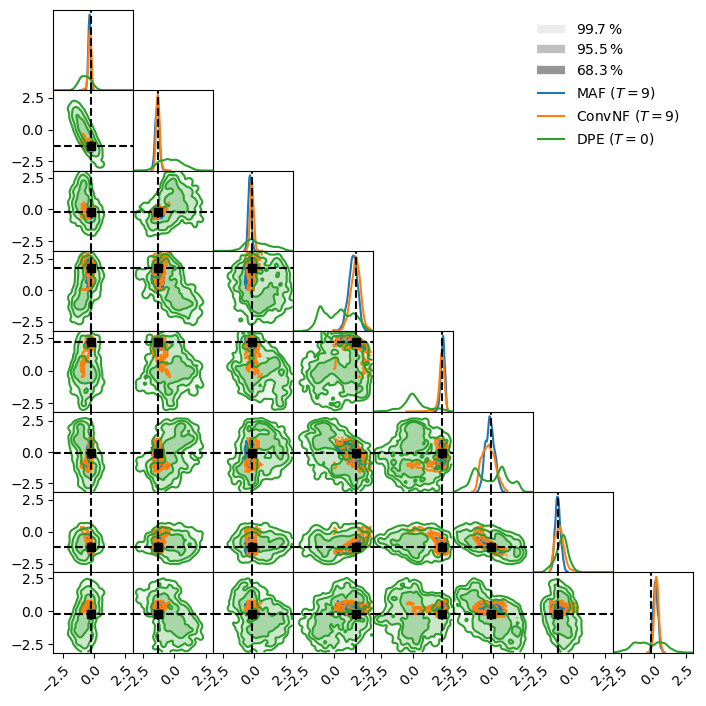

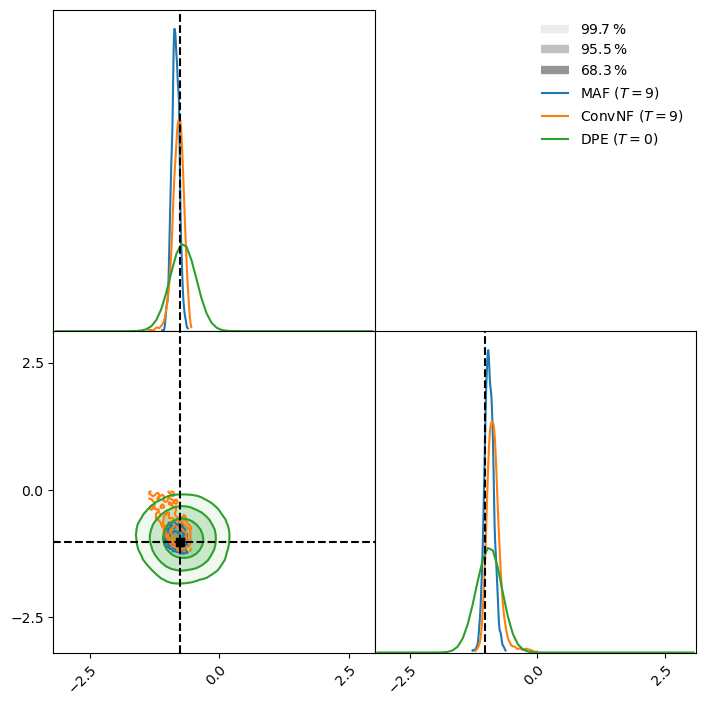

In [14]:
#does not change data

samplerf1 = f'../checkpoints/LZ/{typeM1}/assim/{N}/2.pth'
samplerf2 = f'../checkpoints/LZ/{typeM2}/assim/{N}/2.pth'

window = 10

CONFIG1 = make_maf_lz_config(N,window)
CONFIG2 = make_conv_lz_config(N,window)

# Sampler
sampler1 = build1(**CONFIG1).to(CONFIG1['device'])
sampler2 = build2(**CONFIG2).to(CONFIG2['device'])
with torch.no_grad():
    sampler2(
        simsamp.data[None, None, 0, 0, :, None].to(CONFIG2['device']),
        simsamp.obs[None, :window, 0, :, None].to(CONFIG2['device']),
        simsamp.time[0, 0, None].to(CONFIG2['device']),
    )
state1 = torch.load(f"{samplerf1}", map_location=torch.device(CONFIG1['device']))
state2 = torch.load(f"{samplerf2}", map_location=torch.device(CONFIG2['device']))

sampler1.load_state_dict(state1)
sampler1.eval()
sampler2.load_state_dict(state2)
sampler2.eval()

x_star, y_star, t_star = simsamp.data[0,time], simsamp.obs[0,time-9:time+1], simsamp.time[0,time]
pplz_samp = lambda x,n,gt,m:polar_plot_lz(x,n,offset=5, ensemble=True, gt = gt,mask = m)

with torch.no_grad():
    y_star = y_star[None, ...,None].to(CONFIG1['device'])
    t_star = t_star.unsqueeze(-1)
    xs1 = sampler1.sample(y_star,t_star.to(CONFIG1['device']), samp).cpu()
    xs2 = sampler2.sample(y_star,t_star.to(CONFIG1['device']), samp).cpu()
    
    xs1 = torch.where(xs1.abs() < 3, xs1, 0)
    xs2 = torch.where(xs2.abs() < 3, xs2, 0)
    
    # pplz_samp(xs[:512], N, gt = x_star,m = observer.get_mask())
    # plt.savefig(impth+f'{typeM1}_pred_state_assim.pdf')
    # plt.show()
    # plt.close()

    
    fig = corner(xs1.squeeze(), smooth=1.5, figsize=(7, 7), legend="MAF "+r"$(T = 9)$")
    fig = corner(xs2.squeeze(), smooth=1.5, figsize=(7, 7), legend="ConvNF "+r"$(T = 9)$",figure=fig)
    fig = corner(simsamp.data[:,time], smooth = 1.5, legend="DPE "+r"$(T = 0)$", figure = fig, weights=WEIGHTS)
    mark_point(fig, x_star)
    plt.savefig(impth+f'{typeM1}_{typeM2}_corner_state_assim.pdf')
    plt.show()
    plt.close()

    # CHANGE xs.unsqueeze(-1) for MAF
    ys1 = (observer.observe(xs1.unsqueeze(-1)*sx + mx).squeeze(-1) -my)/sy
    ys2 = (observer.observe(xs2*sx + mx).squeeze(-1) -my)/sy
    fig = corner(ys1.squeeze(), smooth=1.5, figsize=(7, 7), legend="MAF "+r"$(T = 9)$")
    fig = corner(ys2.squeeze(), smooth=1.5, figsize=(7, 7), legend="ConvNF "+r"$(T = 9)$",figure=fig)
    fig = corner(simsamp.obs[:,time], smooth = 1.5, legend="DPE "+r"$(T = 0)$", figure = fig, weights=WEIGHTS)
    mark_point(fig, y_star[:,-1,...].squeeze().cpu())
    plt.savefig(impth+f'{typeM1}_{typeM2}_corner_obs_assim.pdf')
    plt.show()
    plt.close()

    # pplz_samp(ys[:512], N//4, gt = y_star.squeeze()[-1].cpu(),m = None)
    # plt.savefig(impth+f'{typeM1}_pred_obs_assim.pdf')
    # plt.show()
    # plt.close()
    

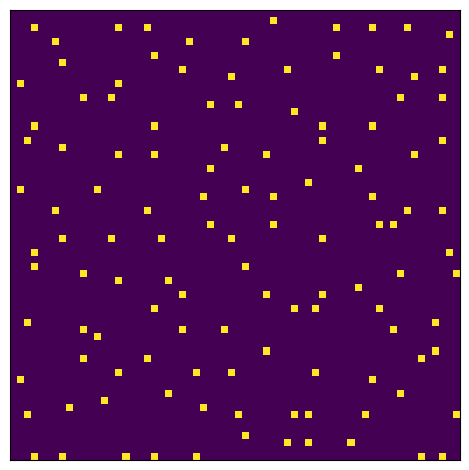

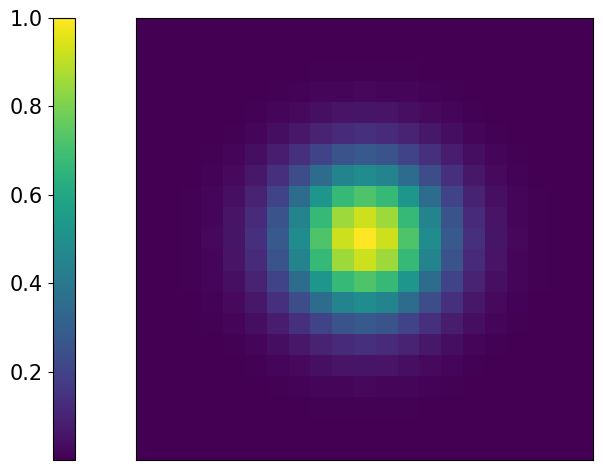

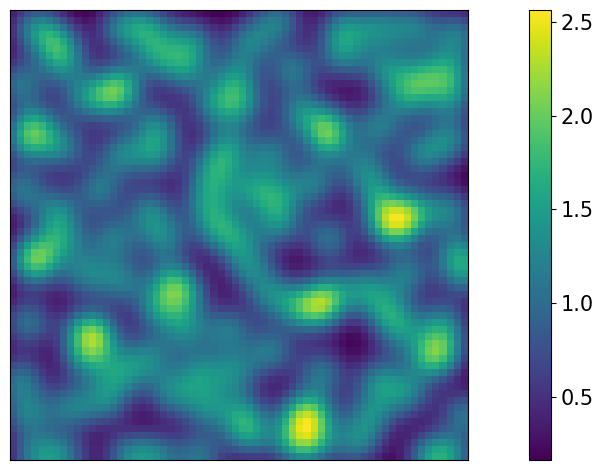

torch.Size([256, 1024])


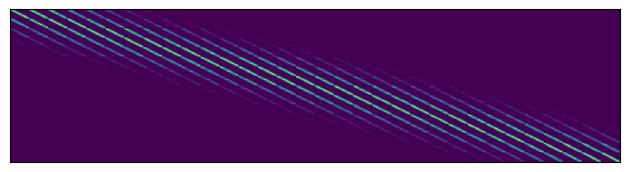

In [15]:
from dasbi.simulators.observators.observator2D import ObservatorStation2D as obs

o = obs((64, 64), (5, 5), (1, 1), (10, 10), (2.5, 2.5))
# o.visualize()

stat = o.get_mask()
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.imshow(stat)
plt.savefig(impth+'Stations.pdf',bbox_inches='tight')
plt.show()

eval_grid = torch.meshgrid(
            torch.arange(-o.aoe[0], o.aoe[0] + 1),
            torch.arange(-o.aoe[1], o.aoe[1] + 1),
            indexing="xy",
        )
eval_grid = torch.cat([X.unsqueeze(-1) for X in eval_grid], dim=-1)

gaussian_kernel = o.gaussian_2D(
    torch.zeros(2), torch.tensor(o.spf), eval_grid
)
gaussian_kernel = (gaussian_kernel / torch.max(gaussian_kernel)).T
plt.imshow(gaussian_kernel, aspect = 'auto')
cb=plt.colorbar(location = 'left', pad = 0.1)
cb.ax.tick_params(labelsize = axis_font)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.savefig(impth+'Kernel.pdf',bbox_inches='tight')
plt.show()
plt.close()
plt.clf()

importance = o.observe(None, True)
plt.imshow(importance[:, :], aspect = 'auto')
cb = plt.colorbar(pad = 0.1)
cb.ax.tick_params(labelsize = axis_font)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.savefig(impth+'ImportanceMap.pdf',bbox_inches='tight')
plt.show()

o = obs((32, 32), (2, 2), (0, 0), (10, 10), (2.5, 2.5))
print(o.get_Obs_mat().shape)
plt.imshow(o.get_Obs_mat())
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()
plt.savefig(impth+'operatorMat.pdf',bbox_inches='tight')
plt.show()

In [20]:
from dasbi.simulators.sim_2D import LZ2D as sim

def kolmo_maf_config(w):
    CONFIG = {
    "embedding": 3,
    "hf": [1024, 2048, 2048, 1024],
    "tf": 4,
    # Data
    "points": 32,
    "noise": 0.5,
    "device": 'cuda',
    # Test with assimilation window
    "x_dim": (1, 2, 32, 32),
    "y_dim": (1, 2*w, 32, 32),
    "y_dim_emb": (1, 20, 32, 32),
    'obs_mask': True, #+1 in y_dim
    "observer_fp": f"experiments/observer2D.pickle",
    }

    return CONFIG

def kolmo_post_config(w):
    CONFIG = {
    # Architecture
    "embedding": 3,
    "depth": 3,
    "input_h": 64,
    # Data
    "points": 32,
    "noise": 0.5,
    "device": 'cuda',
    # Test with assimilation window
    "x_dim": (1, 2, 32, 32),
    "y_dim": (1, 2*w, 6, 6),
    "y_dim_emb": (1, 20, 32, 32),
    'obs_mask': True, #+1 in y_dim
    "observer_fp": f"experiments/observer2D.pickle",
    }

    return CONFIG

path_test = '../test.h5'
observer_fp = "experiments/observer2D.pickle"
data = load_data(path_test)

simv = sim(N=32, M=32, noise=.5)
with open(observer_fp, "rb") as handle:
    observer = pickle.load(handle)
simv.init_observer(observer)
simv.data = data
simv.obs = simv.observe()
simv.time = times[None,...].repeat(data.shape[0],1)
mvx, svx, mvy, svy, _, _ = process_sim(simv)

100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


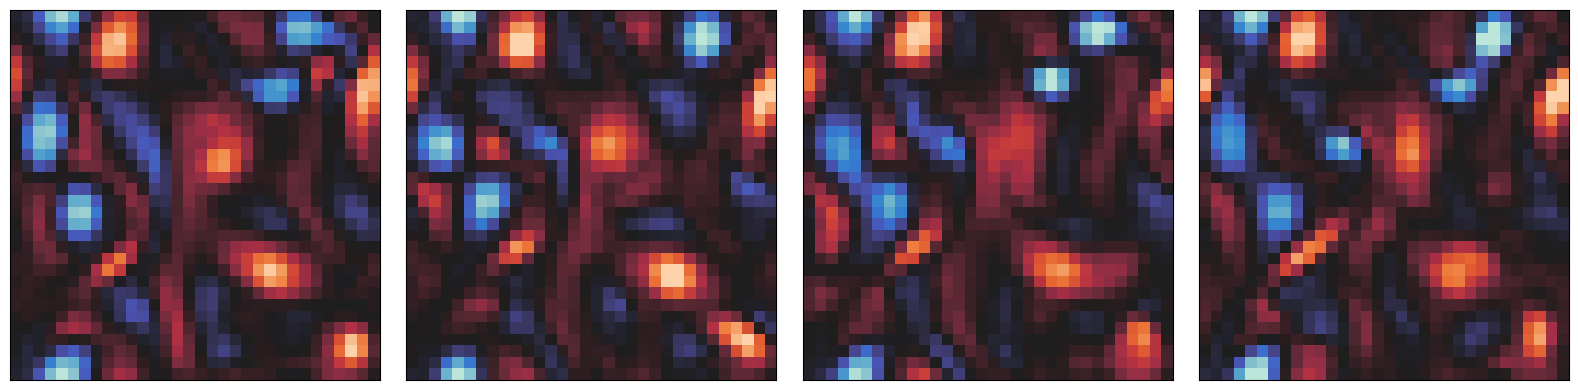

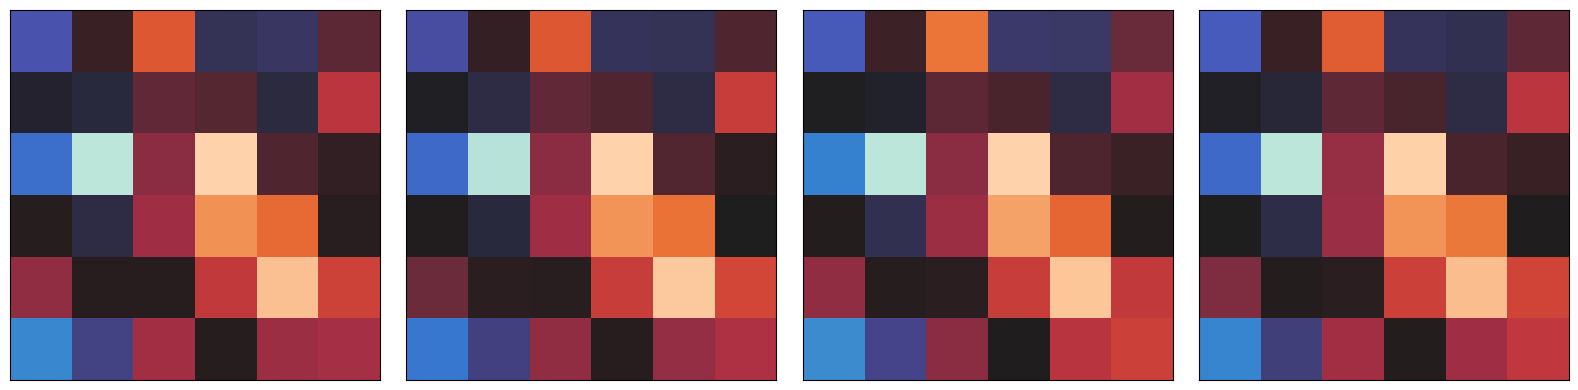

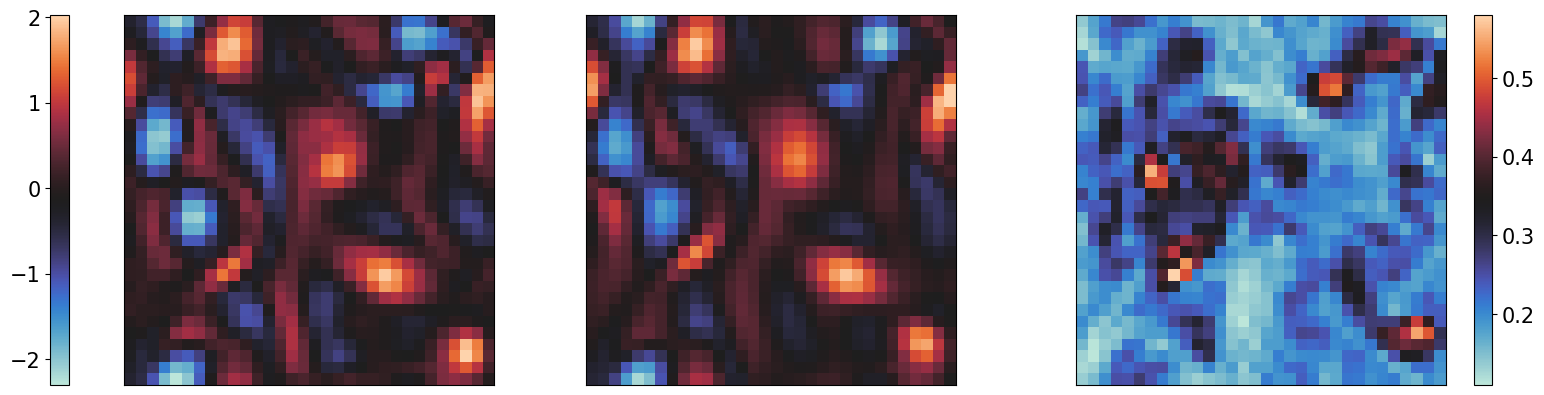

In [54]:
from KOLMO_LIN import vorticity, load_data, build
import seaborn as sns

typeM = 'LINP'

samplerf = f'../checkpoints_2D/KOLMO_{typeM}_STEP.pth'

window = 1

CONFIG = kolmo_post_config(window)

sampler = build(**CONFIG).to(CONFIG['device'])
state = torch.load(f"{samplerf}", map_location=torch.device(CONFIG['device']))
sampler.load_state_dict(state)
sampler.eval()

timestep = 33

x_star, y_star, t_star = simv.data[50,timestep], simv.obs[50,timestep], simv.time[50,timestep] 
B = 128

with torch.no_grad():
    samp = sampler.sample(y_star.unsqueeze(0).to(CONFIG['device']),
                          t_star.unsqueeze(-1).to(CONFIG['device']),B,
                          scales=[mvx.cuda(), svx.cuda(), mvy.cuda(), svy.cuda()]).reshape((B,2,32,32))
    fig,ax = plt.subplots(1,4, sharey='row', figsize = (16,4))

    vstar = vorticity(x_star)
    ax[0].imshow(vstar, cmap = color)
    vsamp = vorticity(samp).squeeze()
    ax[1].imshow(vsamp[0].cpu(), cmap = color, vmin = vstar.min(), vmax = vstar.max())
    ax[2].imshow(vsamp[1].cpu(), cmap = color, vmin = vstar.min(), vmax = vstar.max())
    ax[3].imshow(vsamp[2].cpu(), cmap = color, vmin = vstar.min(), vmax = vstar.max())

    ax[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[3].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
    plt.tight_layout()
    plt.savefig(impth+f'KOLMO_samp_{typeM}.pdf')

    plt.show()
    plt.close()

    y_samp = (observer.observe(samp.cpu()*svx + mvx) -mvy)/svy

    fig,ax = plt.subplots(1,4, sharey='row', figsize = (16,4))

    vystar = vorticity(y_star)
    ax[0].imshow(vystar, cmap = color)
    vysamp = vorticity(y_samp).squeeze()
    ax[1].imshow(vysamp[0].cpu(), cmap = color, vmin = vystar.min(), vmax = vystar.max())
    ax[2].imshow(vysamp[1].cpu(), cmap = color, vmin = vystar.min(), vmax = vystar.max())
    ax[3].imshow(vysamp[2].cpu(), cmap = color, vmin = vystar.min(), vmax = vystar.max())

    ax[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[3].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
    plt.tight_layout()
    plt.savefig(impth+f'KOLMO_samp_{typeM}_obs.pdf')

    plt.show()
    plt.close()

    fig,ax = plt.subplots(1,3, sharey='row', figsize = (16,4))
    imsamp = ax[0].imshow(vstar, cmap = color)
    ax[1].imshow(vsamp.mean(0).cpu(), cmap = color, vmin = vstar.min(), vmax = vstar.max())
    im = ax[2].imshow(vsamp.std(0).cpu(), cmap = color)

    ax[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
    plt.tight_layout()
    cb = plt.colorbar(imsamp, ax = ax[0], location= 'left')
    cb.ax.tick_params(labelsize = axis_font)
    cb = plt.colorbar(im, ax = ax[2])
    cb.ax.tick_params(labelsize = axis_font)
    plt.savefig(impth+f'KOLMO_samp_{typeM}_mean_std.pdf')

    plt.show()
    plt.close()

100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


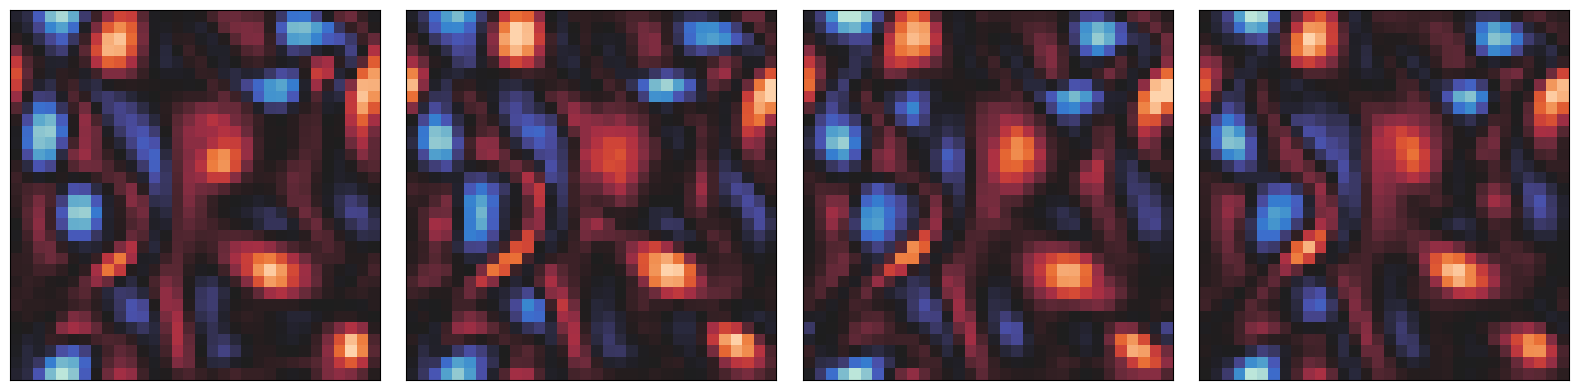

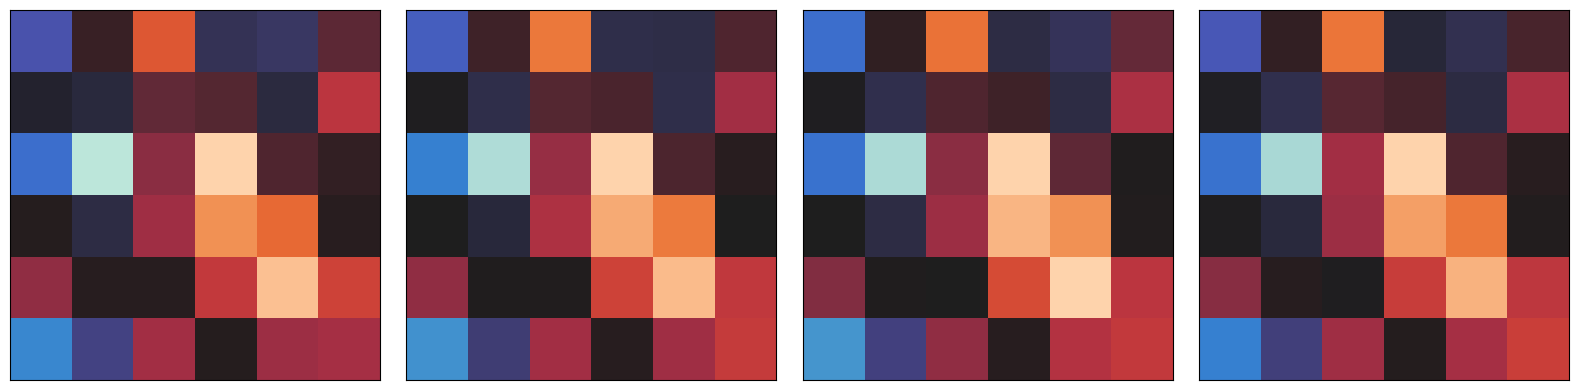

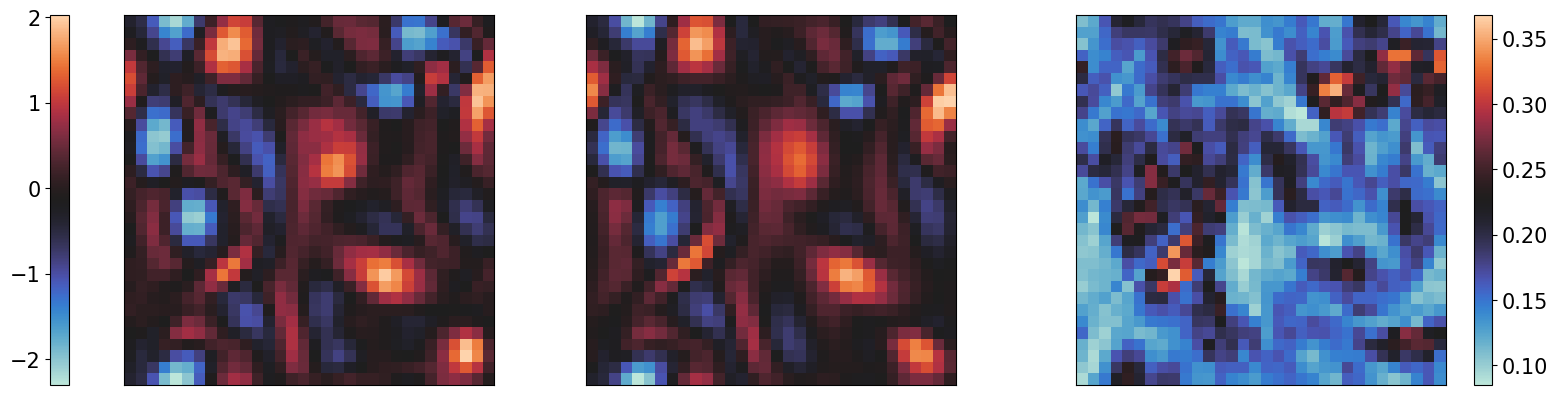

In [53]:
samplerf = f'../checkpoints_2D/KOLMO_{typeM}_ASSIM.pth'

window = 10

CONFIG = kolmo_post_config(window)

sampler = build(**CONFIG).to(CONFIG['device'])
state = torch.load(f"{samplerf}", map_location=torch.device(CONFIG['device']))
sampler.load_state_dict(state)
sampler.eval()

x_star, y_star, t_star = simv.data[50,timestep], simv.obs[50,timestep-9:timestep+1].reshape(2*window, 6,6), simv.time[50,timestep] 

with torch.no_grad():
    samp = sampler.sample(y_star.to(CONFIG['device']).unsqueeze(0),t_star.unsqueeze(-1).to(CONFIG['device']),B).reshape((B,2,32,32))
    fig,ax = plt.subplots(1,4, sharey='row', figsize = (16,4))

    vstar = vorticity(x_star)
    ax[0].imshow(vstar, cmap = color)
    vsamp = vorticity(samp).squeeze()
    ax[1].imshow(vsamp[0].cpu(), cmap = color, vmin = vstar.min(), vmax = vstar.max())
    ax[2].imshow(vsamp[1].cpu(), cmap = color, vmin = vstar.min(), vmax = vstar.max())
    ax[3].imshow(vsamp[2].cpu(), cmap = color, vmin = vstar.min(), vmax = vstar.max())

    ax[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[3].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
    plt.tight_layout()
    plt.savefig(impth+f'KOLMO_samp_{typeM}_assim.pdf')

    plt.show()
    plt.close()

    y_samp = (observer.observe(samp.cpu()*svx + mvx) -mvy)/svy

    fig,ax = plt.subplots(1,4, sharey='row', figsize = (16,4))

    vystar = vorticity(y_star.reshape(1,window,2,6,6)[:,-1:]).squeeze()
    ax[0].imshow(vystar, cmap = color)
    vysamp = vorticity(y_samp)
    ax[1].imshow(vysamp[0].cpu(), cmap = color, vmin = vystar.min(), vmax = vystar.max())
    ax[2].imshow(vysamp[1].cpu(), cmap = color, vmin = vystar.min(), vmax = vystar.max())
    ax[3].imshow(vysamp[2].cpu(), cmap = color, vmin = vystar.min(), vmax = vystar.max())

    ax[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[3].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
    plt.tight_layout()
    plt.savefig(impth+f'KOLMO_samp_{typeM}_obs_assim.pdf')

    plt.show()
    plt.close()

    fig,ax = plt.subplots(1,3, sharey='row', figsize = (16,4))
    imsamp = ax[0].imshow(vstar, cmap = color)
    ax[1].imshow(vsamp.mean(0).cpu(), cmap = color, vmin = vstar.min(), vmax = vstar.max())
    im = ax[2].imshow(vsamp.std(0).cpu(), cmap = color)

    ax[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
    plt.tight_layout()
    cb = plt.colorbar(imsamp, ax = ax[0], location= 'left')
    cb.ax.tick_params(labelsize = axis_font)
    cb = plt.colorbar(im, ax = ax[2])
    cb.ax.tick_params(labelsize = axis_font)
    plt.savefig(impth+f'KOLMO_samp_{typeM}_mean_std_assim.pdf')

    plt.show()
    plt.close()

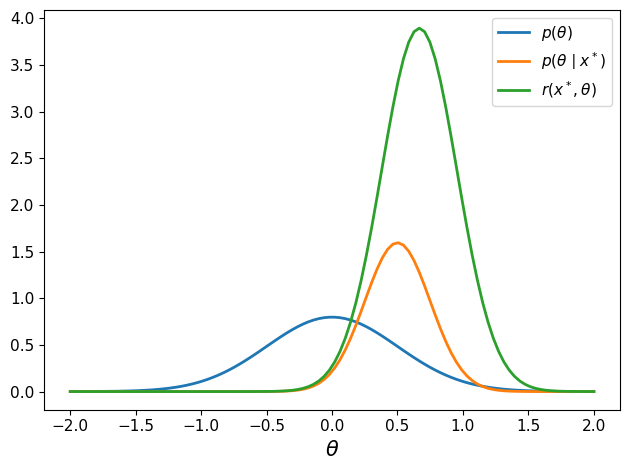

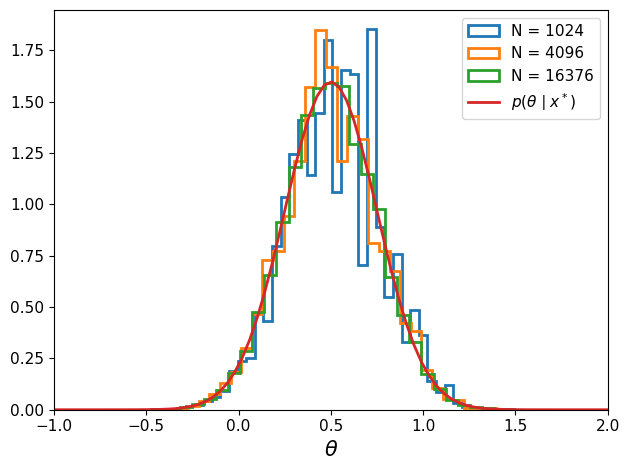

In [ ]:
x = torch.linspace(-2,2,100)
dist_prior = torch.distributions.Normal(torch.tensor(0.), torch.tensor(.5))
dist_post = torch.distributions.Normal(torch.tensor(.5), torch.tensor(.25))

prior = dist_prior.log_prob(x).exp()
post = dist_post.log_prob(x).exp()
ratio = lambda x:dist_post.log_prob(x).exp()/dist_prior.log_prob(x).exp()

plt.plot(x,prior, label = r'$p(\theta)$',linewidth = lw)
plt.plot(x,post, label = r'$p(\theta \mid x^*)$',linewidth = lw)
plt.plot(x,ratio(x), label = r'$r(x^*,\theta)$',linewidth = lw)
plt.xlabel(r'$\theta$', fontsize = axis_font)
plt.tick_params('both', labelsize = legend_font)
plt.legend(fontsize = legend_font)
plt.tight_layout()
plt.savefig(impth+'Post_Prior_ratio.pdf')
plt.show()
plt.close()


for n in [1024,4096,4094*4]:
    samp = dist_prior.sample((n,))
    plt.hist(samp, bins=64, density=True, weights=ratio(samp), histtype='step',linewidth = lw, label = f'N = {n}')
    plt.xlim([-1,2])

plt.plot(x,post, label = r'$p(\theta \mid x^*)$',linewidth = lw)
plt.legend(fontsize = legend_font)
plt.xlabel(r'$\theta$', fontsize = axis_font)
plt.tick_params('both', labelsize = legend_font)
plt.tight_layout()
plt.savefig(impth+'Post_DPE.pdf')
plt.show()
plt.close()

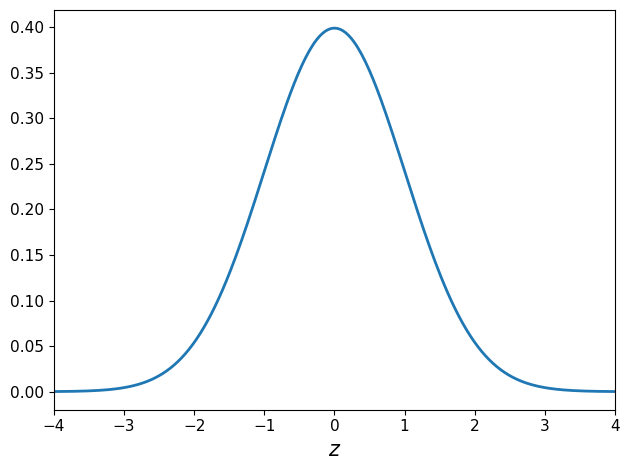

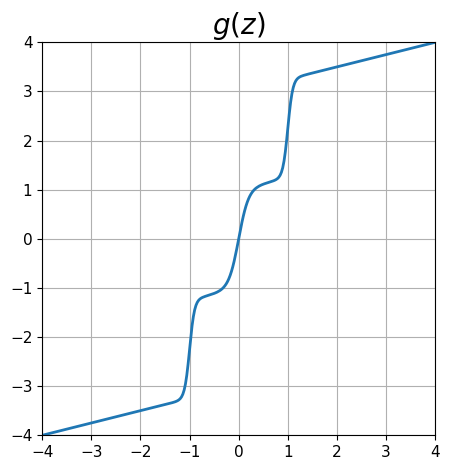

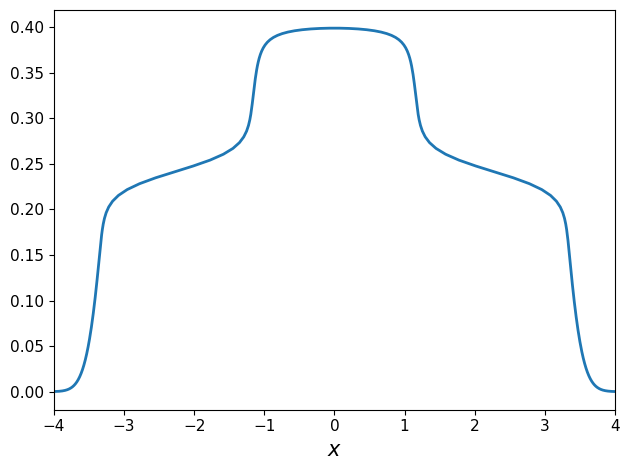

In [ ]:
dist = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1))
x = torch.linspace(-4,4,300)
plt.plot(x,dist.log_prob(x).exp(), linewidth = lw)
plt.xlabel(r"$z$",fontsize = axis_font)
plt.tick_params('both', labelsize = legend_font)
plt.xlim(-4,4)
plt.tight_layout()
plt.savefig(impth+"BaseDist.svg")
plt.show()

def f(x):
    # y = torch.zeros_like(x)
    # y = x - 3.375
    # y[x > -2] = x[x > -2]/4 - 4.875
    # y[x > -0.5] = 10*x[x > -0.5] 
    # y[x > 0.5] = x[x > 0.5]/5 + 4.9
    # y[x > 2] = x[x > 2] + 3.3
    y = (10*x-10).tanh() + (10*x+10).tanh() + (5*x).tanh() + 1/4 * x
    return y

plt.plot(x,f(x), linewidth = lw)
plt.grid()
plt.title(r"$g(z)$", fontsize = 20)
plt.tick_params('both', labelsize = legend_font)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.savefig(impth+"bijFunc.svg")
plt.show()

plt.plot(f(x), dist.log_prob(x).exp(), linewidth = lw)
plt.xlabel(r"$x$",fontsize = axis_font)
plt.tick_params('both', labelsize = legend_font)
plt.xlim(-4,4)
plt.tight_layout()
plt.savefig(impth+"complexDist.svg")
plt.show()

In [182]:
import pandas as pd

res = pd.read_csv('../resWNB.csv')
# print(res['N_ms'].unique())
subres = res[(res['N_ms'].notna()) & (res['N_ms'] != 'score') & (res['N_ms'] != 'score_lin')]
# print(subres.shape)
res_mean = [[],[],[],[]]
res_std = [[],[],[],[]]
names = ['State (T = 0)', 'State (T = 9)', 'Pred (T = 0)', 'Pred (T = 9)']
for t,typer in enumerate(['LZ96_scaling_step', 'LZ96_scaling_assim','LZ96_scaling_step_obs', 'LZ96_diag_assim_obs']):
    print(typer)
    for i in range(3,9):
        N = 2**i
        dat = subres[(subres['Group'] == typer) & (subres['points'] == N)]['loss_val']
        print(f'{dat.mean() = :.3f}', '+/-', f'{dat.std() = :.3f}')
        res_mean[t].append(dat.mean())
        res_std[t].append(dat.std())

# for r, dat in enumerate(res_mean):
#     plt.errorbar(torch.arange(3,9), dat, yerr=res_std[r], alpha = 1,capsize=5, capthick=2, label = names[r], linewidth = lw)
    
# plt.legend(fontsize = legend_font)
# plt.ylim(.48,1)
# plt.xlabel(r"$\log_2(N)$", fontsize = axis_font)
# plt.ylabel("AUC", fontsize = axis_font)
# plt.grid()
# plt.tick_params('both', labelsize = legend_font)
# plt.tight_layout()
# # plt.semilogy()
# # plt.savefig(impth+"POST_AUC.pdf")
# plt.show()

LZ96_scaling_step
dat.mean() = 2.491 +/- dat.std() = 0.066
dat.mean() = 8.717 +/- dat.std() = 0.109
dat.mean() = 18.123 +/- dat.std() = 0.331
dat.mean() = 36.275 +/- dat.std() = 2.587
dat.mean() = 70.333 +/- dat.std() = 3.334
dat.mean() = 135.685 +/- dat.std() = 2.453
LZ96_scaling_assim
dat.mean() = -5.469 +/- dat.std() = 0.081
dat.mean() = -2.257 +/- dat.std() = 0.115
dat.mean() = -1.836 +/- dat.std() = 1.246
dat.mean() = -11.931 +/- dat.std() = 0.933
dat.mean() = -20.719 +/- dat.std() = 1.285
dat.mean() = -33.674 +/- dat.std() = 1.479
LZ96_scaling_step_obs
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
LZ96_diag_assim_obs
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
dat.mean() = nan +/- dat.std() = nan
dat.mean